In [1]:
import os
import numpy as np

import tensorflow as tf

from tensorflow.python.keras import backend as K

from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from deepcell.applications import CytoplasmSegmentation
from deepcell.datasets.cytoplasm import hela_s3

from deepcell_toolbox import utils
from deepcell_toolbox.utils import resize, tile_image, untile_image

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.6/dist-packages/deepcell/utils/__init__.py:49: UserWarning: To use `compute_overlap`, the C extensions must be built using `python setup.py build_ext --inplace`
  warnings.warn('To use `compute_overlap`, the C extensions must be built '


In [2]:
((X_train, y_train),(X_test, y_test)) = hela_s3.load_data()
im = X_test
im.shape

i=0
image = im[i, ..., 0]
image = np.expand_dims(image, 0)
image = np.expand_dims(image, -1)
image = image.astype('uint16')
image = image[:,:512,:512]

632602624/632595468 [==============================] - 16s 0us/step


In [ ]:
app = CytoplasmSegmentation()
print('Training Resolution:', app.model_mpp, 'microns per pixel')

labeled_im = app.predict(image, image_mpp=0.65)      
labeled_im.shape

In [ ]:
i = 0
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(im[0, ..., 0])
ax[1].imshow(labeled_im[i, ..., 0], cmap='jet')
plt.show()

In [ ]:
dtype='int32'
#dtype = 'uint16'
input_shape = (256, 256, 1)
stride_ratio = 0.5

difference_threshold = 0.1


initial_image = image.astype(dtype)

tiles, tiles_info = utils.tile_image(initial_image, model_input_shape=input_shape, stride_ratio=stride_ratio)

# version of untile image defined above
#untiled_image = _untile_image(tiles, tiles_info, model_input_shape=input_shape) 

#version of untile image defined in deepcell-toolbox - need to edit that and restart kernel to see changes
untiled_image = untile_image(tiles, tiles_info) 

diff = initial_image - untiled_image

print('Avg diff = ', np.average(diff))
print('Avg init = ', np.average(initial_image))
print('Avg untiled = ', np.average(untiled_image))

print('Difference is: ', np.average(diff)/np.average(untiled_image))


fig, ax = plt.subplots(1, 3, figsize=(10, 8))
ax[0].imshow(initial_image[i, ..., 0].astype('float32'))
ax[1].imshow(untiled_image[i, ..., 0].astype('float32'))
ax[2].imshow(diff[i, ..., 0].astype('float32'))
plt.show()

tile_image: model_input_shape =  (128, 128, 1) , stride_ratio =  0.6
image_shape is:  [4, 284, 284, 1] , stride_ratio is:  0.6
Avg init =  5.0
Avg untiled =  5.0007806
Difference is:  -0.00015628878


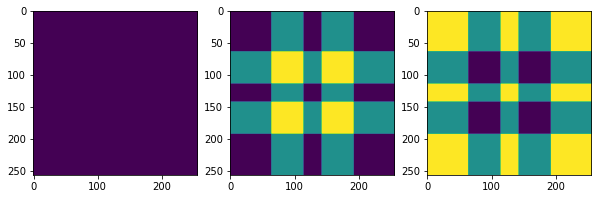

In [59]:
dtype='float32'

input_shape = (128, 128, 1)

shape = (4, 256, 256, 1)

#initial_image = (np.random.random(shape) * 100).astype(dtype)
initial_image = (np.zeros(shape)+5).astype(dtype)

tiles, tiles_info = tile_image_new(initial_image, model_input_shape=input_shape, stride_ratio=0.6)

#untiled_image = untile_image_test(tiles, tiles_info, model_input_shape=input_shape)
untiled_image = untile_image_new(tiles, tiles_info)

diff = initial_image - untiled_image

print('Avg init = ', np.average(initial_image))
print('Avg untiled = ', np.average(untiled_image))

# rough estimate of relative difference between input & ouput
print('Difference is: ', np.average(diff)/np.average(untiled_image))

np.testing.assert_allclose(initial_image, untiled_image, 1e-1)


fig, ax = plt.subplots(1, 3, figsize=(10, 8))
ax[0].imshow(initial_image[i, ..., 0])
ax[1].imshow(untiled_image[i, ..., 0])
ax[2].imshow(diff[i, ..., 0])
plt.show()

In [35]:
import scipy.signal

def tile_image_new(image, model_input_shape=(512, 512), stride_ratio=0.75):
    """
    Tile large image into many overlapping tiles of size "model_input_shape".
    Args:
        image (numpy.array): The image to tile, must be rank 4.
        model_input_shape (tuple): The input size of the model.
        stride_ratio (float): The stride expressed as a fraction of the tile size
    Returns:
        tuple(numpy.array, dict): An tuple consisting of an array of tiled
            images and a dictionary of tiling details (for use in un-tiling).
    Raises:
        ValueError: image is not rank 4.
    """
    if image.ndim != 4:
        raise ValueError('Expected image of rank 2, 3 or 4, got {}'.format(
            image.ndim))

    image_size_x, image_size_y = image.shape[1:3]
    tile_size_x = model_input_shape[0]
    tile_size_y = model_input_shape[1]

    ceil = lambda x: int(np.ceil(x))
    round_to_even = lambda x: int(np.ceil(x / 2.0) * 2)

    stride_x = round_to_even(stride_ratio * tile_size_x)
    stride_y = round_to_even(stride_ratio * tile_size_y)

    if stride_x > tile_size_x:
        stride_x = tile_size_x

    if stride_y > tile_size_y:
        stride_y = tile_size_y

        

    
    rep_number_x = max(ceil((image_size_x - tile_size_x) / stride_x + 1), 1)
    rep_number_y = max(ceil((image_size_y - tile_size_y) / stride_y + 1), 1)
    new_batch_size = image.shape[0] * rep_number_x * rep_number_y

    tiles_shape = (new_batch_size, tile_size_x, tile_size_y, image.shape[3])
    tiles = np.zeros(tiles_shape, dtype=image.dtype)

    #print('stride_x is {} and stride y is {}'.format(stride_x, stride_y))
    #print('image_size_x is {} and image_size_y is {}'.format(image_size_x, image_size_y))
    #print('tile_size_x is {} and tile_size_y is {}'.format(tile_size_x, tile_size_x))
    #print('rep_number_x is {} and rep_number_y is {}'.format(rep_number_x, rep_number_y))
    
    # Calculate overlap of last tile
    overlap_x = (tile_size_x + stride_x * (rep_number_x - 1)) - image_size_x
    overlap_y = (tile_size_y + stride_y * (rep_number_y - 1)) - image_size_y

    # Calculate padding needed to account for overlap and pad image accordingly
    pad_x = (int(np.ceil(overlap_x / 2)), int(np.floor(overlap_x / 2)))
    pad_y = (int(np.ceil(overlap_y / 2)), int(np.floor(overlap_y / 2)))
    pad_null = (0, 0)
    padding = (pad_null, pad_x, pad_y, pad_null)
    image = np.pad(image, padding, 'constant')

    #print('pad_x is {} and pad_y is {}'.format(pad_x, pad_y))
    
    counter = 0
    batches = []
    x_starts = []
    x_ends = []
    y_starts = []
    y_ends = []
    overlaps_x = []
    overlaps_y = []

    for b in range(image.shape[0]):
        for i in range(rep_number_x):
            for j in range(rep_number_y):
                x_axis = 1
                y_axis = 2

                # Compute the start and end for each tile
                if i != rep_number_x - 1:  # not the last one
                    x_start, x_end = i * stride_x, i * stride_x + tile_size_x
                else:
                    x_start, x_end = image.shape[x_axis] - tile_size_x, image.shape[x_axis]

                if j != rep_number_y - 1:  # not the last one
                    y_start, y_end = j * stride_y, j * stride_y + tile_size_y
                else:
                    y_start, y_end = image.shape[y_axis] - tile_size_y, image.shape[y_axis]

                # Compute the overlaps for each tile
                if i == 0:
                    overlap_x = (0, tile_size_x - stride_x)
                elif i == rep_number_x - 2:
                    overlap_x = (tile_size_x - stride_x, tile_size_x - image.shape[x_axis] + x_end)
                elif i == rep_number_x - 1:
                    overlap_x = ((i - 1) * stride_x + tile_size_x - x_start, 0)
                else:
                    overlap_x = (tile_size_x - stride_x, tile_size_x - stride_x)

                if j == 0:
                    overlap_y = (0, tile_size_y - stride_y)
                elif j == rep_number_y - 2:
                    overlap_y = (tile_size_y - stride_y, tile_size_y - image.shape[y_axis] + y_end)
                elif j == rep_number_y - 1:
                    overlap_y = ((j - 1) * stride_y + tile_size_y - y_start, 0)
                else:
                    overlap_y = (tile_size_y - stride_y, tile_size_y - stride_y)

                tiles[counter] = image[b, x_start:x_end, y_start:y_end, :]
                batches.append(b)
                x_starts.append(x_start)
                x_ends.append(x_end)
                y_starts.append(y_start)
                y_ends.append(y_end)
                overlaps_x.append(overlap_x)
                overlaps_y.append(overlap_y)
                counter += 1

    tiles_info = {}
    tiles_info['batches'] = batches
    tiles_info['x_starts'] = x_starts
    tiles_info['x_ends'] = x_ends
    tiles_info['y_starts'] = y_starts
    tiles_info['y_ends'] = y_ends
    tiles_info['overlaps_x'] = overlaps_x
    tiles_info['overlaps_y'] = overlaps_y
    tiles_info['stride_x'] = stride_x
    tiles_info['stride_y'] = stride_y
    tiles_info['tile_size_x'] = tile_size_x
    tiles_info['tile_size_y'] = tile_size_y
    tiles_info['stride_ratio'] = stride_ratio
    tiles_info['image_shape'] = image.shape
    tiles_info['dtype'] = image.dtype
    tiles_info['pad_x'] = pad_x
    tiles_info['pad_y'] = pad_y

    return tiles, tiles_info


In [4]:
import os
import numpy as np

import tensorflow as tf

from tensorflow.python.keras import backend as K

from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from deepcell.applications import CytoplasmSegmentation
from deepcell.datasets.cytoplasm import hela_s3

from deepcell_toolbox import utils
from deepcell_toolbox.utils import resize, tile_image, untile_image

In [20]:
from itertools import product

import numpy as np
from skimage.measure import label

def test_untile_image():
    shapes = [
        (3, 8, 16, 2),
        (1, 64, 64, 1),
        (1, 41, 58, 1),
        (1, 93, 61, 1),
        
    ]
    rand_rel_diff_thresh = 2e-2
    model_input_shapes = [(16, 20), (32, 32), (41, 51), (64, 64), (100, 90)]
    stride_ratios = [0.33, 0.4, 0.5, 0.51, 0.66, 0.75, 1]
    dtypes = ['int32', 'float32', 'uint16', 'float16']
    prod = product(shapes, model_input_shapes, stride_ratios, dtypes)

    # Test that randomly generated arrays are unchanged within a moderate tolerance
    for shape, input_shape, stride_ratio, dtype in prod:

        big_image = (np.random.random(shape) * 100).astype(dtype)
        tiles, tiles_info = utils.tile_image(big_image, model_input_shape=input_shape,
                                             stride_ratio=stride_ratio)

        untiled_image = utils.untile_image(tiles, tiles_info)

        assert untiled_image.dtype == dtype
        assert untiled_image.shape == shape

        np.testing.assert_allclose(big_image, untiled_image, rand_rel_diff_thresh)

    # Test that arrays of zeros are unchanged by tile/untile
    for shape, input_shape, stride_ratio, dtype in prod:

        big_image_zeros = np.zeros(shape).astype(dtype)
        tiles, tiles_info = utils.tile_image(big_image_zeros, model_input_shape=input_shape,
                                             stride_ratio=stride_ratio)
        untiled_image_zeros = utils.untile_image(tiles, tiles_info)
        assert untiled_image_zeros.dtype == dtype
        assert untiled_image_zeros.shape == shape
        assert big_image_zeros == untiled_image_zeros

In [21]:
test_untile_image()

AssertionError: 
Not equal to tolerance rtol=0.02, atol=0

Mismatch: 9.57%
Max absolute difference: 12
Max relative difference: 0.13793103
 x: array([[[[88],
         [13],
         [15],...
 y: array([[[[88],
         [13],
         [15],...

In [18]:
rand_rel_diff_thresh = 1e-2
shape = (1, 6, 8, 1)
input_shape = (4, 4)
stride_ratio = 0.5
dtype = 'int32'

big_image = (np.random.random(shape) * 100).astype(dtype)
tiles, tiles_info = utils.tile_image(big_image, model_input_shape=input_shape,
                                     stride_ratio=stride_ratio)

untiled_image = utils.untile_image(tiles, tiles_info)

assert untiled_image.dtype == dtype
assert untiled_image.shape == shape

np.testing.assert_allclose(big_image, untiled_image, rand_rel_diff_thresh)

AssertionError: 
Not equal to tolerance rtol=0.01, atol=0

Mismatch: 64.6%
Max absolute difference: 30
Max relative difference: 0.23255814
 x: array([[[[55],
         [62],
         [56],...
 y: array([[[[ 55],
         [ 62],
         [ 64],...

In [19]:
big_image[0, ..., 0]

array([[55, 62, 56, 51, 26, 37, 34, 30],
       [99, 27, 56, 90, 12,  3, 13, 38],
       [10, 47, 53, 93, 35, 99,  8, 90],
       [53, 98, 97, 11, 51, 93, 36, 95],
       [78, 88, 23, 48, 99,  7, 61, 79],
       [75, 37, 75, 63, 86, 48, 98, 28]], dtype=int32)

In [20]:
untiled_image[0, ..., 0]

array([[ 55,  62,  64,  58,  29,  42,  34,  30],
       [ 99,  27,  64, 102,  13,   3,  13,  38],
       [ 11,  53,  69, 121,  45, 129,   9, 102],
       [ 60, 112, 126,  14,  66, 121,  41, 108],
       [ 78,  88,  26,  54, 113,   8,  61,  79],
       [ 75,  37,  85,  72,  98,  54,  98,  28]], dtype=int32)

In [26]:
tiles[...]

array([], shape=(0, 16, 16, 1), dtype=int32)

In [6]:
def test_tile_image():
    shapes = [
        (4, 21, 21, 1),
        (4, 21, 31, 2),
        (4, 31, 21, 3),
    ]
    model_input_shapes = [(3, 3), (5, 5), (7, 7), (12, 12)]

    stride_ratios = [0.25, 0.33, 0.5, 0.66, 0.75, 0.8, 1]

    dtypes = ['int32', 'float32', 'uint16', 'float16']

    prod = product(shapes, model_input_shapes, stride_ratios, dtypes)

    for shape, input_shape, stride_ratio, dtype in prod:
        big_image = (np.random.random(shape) * 100).astype(dtype)
        tiles, tiles_info = utils.tile_image(
            big_image, input_shape,
            stride_ratio=stride_ratio)

        assert tiles.shape[1:] == input_shape + (shape[-1],)
        assert tiles.dtype == big_image.dtype

        ceil = lambda x: int(np.ceil(x))
        round_to_even = lambda x: int(np.ceil(x / 2.0) * 2)

        image_size_x, image_size_y = big_image.shape[1:3]
        tile_size_x = input_shape[0]
        tile_size_y = input_shape[1]

        stride_x = round_to_even(stride_ratio * tile_size_x)
        stride_y = round_to_even(stride_ratio * tile_size_y)

        if stride_x > tile_size_x:
            stride_x = tile_size_x
        if stride_y > tile_size_y:
            stride_y = tile_size_y

        rep_number_x = ceil((image_size_x - tile_size_x) / stride_x + 1)
        rep_number_y = ceil((image_size_y - tile_size_y) / stride_y + 1)

        expected_batches = big_image.shape[0] * rep_number_x * rep_number_y

        assert tiles.shape[0] == expected_batches

In [7]:
test_tile_image()